In [529]:
using StaticArrays, ProgressMeter
include("../code/headers.jl")

# 1. Decimation

In [2]:
function decimate!(sp, src; decsteps=10, freevars=collect(1:size(sp.H,2)), kw...)
    iteration!(sp; maxiter=1000, damp=0.5, kw...)
    cnt = 0
    maxvardeg = maximum(sum(sp.H, dims=1))
    while !isempty(freevars)
        cnt += 1
        ε = iteration!(sp; maxiter=100, damp=0.5, kw...)
        # rank variables with the most decided at the end
        mag = [findmax([sum(p[begin:-1]), sum(p[1:end])]) for p in sp.survey]
        mag_sign = [(m[2] - 1.5)*2 for m in mag]
        sort!(freevars, by=i->abs(mag[i][1]))
        # fix the highest-ranked with a strong field
        freevars, tofix = freevars[1:end-decsteps-1], freevars[max(1,end-decsteps+1):end]
        println("Step $cnt - fixing: $tofix")
        sp.efield[tofix] .= (maxvardeg+1)*sp.J.*mag_sign[tofix]  
        # print stuff
        σ = sign.(argmax.(sp.survey))
        x = σ .== -1
        z = sp.H*x .% 2
        ovl = dot(σ, src) / length(src)
        println("Unsat ", sum(z), ". Free vars ", length(freevars), ". Ovl ", round(ovl,digits=3),
            ". ε=", round(ε,sigdigits=3))
    end
end

decimate! (generic function with 1 method)

In [111]:
m = factorial(7)
R = 0.25
r = 1 - 3R
n = round(Int, 3m/(2+r))
Λ = OffsetVector([0,0,1-r,r], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
nedges = 3m
# convert to edge degree convention to express the degree profile
lambda, rho = nodes2edges(Λ[1:end], K[1:end])
# build graph
fg = ldpc_graphGF2(n,m,nedges,lambda,rho)
H = copy(fg.H)
x0 = rand((0,1), size(H,2))
src = (-1).^x0
J = 20
# init=OffsetArray(MVector{2J+1}(fill(1/(2J+1),2J+1)), -J:J)
init=OffsetArray(MVector{2J+1}(rand(2J+1)), -J:J)
y = 0.2
sp = survey_propagation(H; field=src, init, y=y);

In [6]:
decimate!(sp, src, decsteps=1)

Step 1 - fixing: [2660]
Unsat 443.0. Free vars 6718. Ovl 0.6081845238095238
Step 2 - fixing: [3440]
Unsat 445.0. Free vars 6716. Ovl 0.6160714285714286
Step 3 - fixing: [1249]
Unsat 450.0. Free vars 6714. Ovl 0.625297619047619
Step 4 - fixing: [5720]
Unsat 450.5. Free vars 6712. Ovl 0.6342261904761904
Step 5 - fixing: [4509]
Unsat 449.5. Free vars 6710. Ovl 0.6430059523809524
Step 6 - fixing: [2877]
Unsat 453.5. Free vars 6708. Ovl 0.6522321428571428
Step 7 - fixing: [1025]
Unsat 453.5. Free vars 6706. Ovl 0.6610119047619047
Step 8 - fixing: [135]
Unsat 452.5. Free vars 6704. Ovl 0.6699404761904761


LoadError: TaskFailedException:
InterruptException:
Stacktrace:
 [1] Array at ./boot.jl:406 [inlined]
 [2] Array at ./boot.jl:415 [inlined]
 [3] Array at ./boot.jl:423 [inlined]
 [4] similar at /home/crotti/.julia/packages/OffsetArrays/PXUn7/src/OffsetArrays.jl:244 [inlined]
 [5] fill(::Float64, ::Tuple{UnitRange{Int64}}) at /home/crotti/.julia/packages/OffsetArrays/PXUn7/src/OffsetArrays.jl:248
 [6] fill at ./array.jl:471 [inlined]
 [7] ⊛(::OffsetArray{Float64,1,Array{Float64,1}}, ::OffsetArray{Float64,1,Array{Float64,1}}) at /home/crotti/sourcecoding/code/sp.jl:28
 [8] cavity!(::Array{OffsetArray{Float64,1,Array{Float64,1}},1}, ::Array{OffsetArray{Float64,1,Array{Float64,1}},1}, ::typeof(⊛), ::OffsetArray{Float64,1,Array{Float64,1}}) at /home/crotti/sourcecoding/code/cavity.jl:25
 [9] update_var!(::SurveyPropagation{Int64,OffsetArray{Float64,1,Array{Float64,1}}}, ::Int64; damp::Float64, rein::Float64) at /home/crotti/sourcecoding/code/sp.jl:90
 [10] macro expansion at /home/crotti/sourcecoding/code/sp.jl:357 [inlined]
 [11] (::var"#244#threadsfor_fun#432"{Float64,Float64,SurveyPropagation{Int64,OffsetArray{Float64,1,Array{Float64,1}}},Array{Float64,1},UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:81
 [12] (::var"#244#threadsfor_fun#432"{Float64,Float64,SurveyPropagation{Int64,OffsetArray{Float64,1,Array{Float64,1}}},Array{Float64,1},UnitRange{Int64}})() at ./threadingconstructs.jl:48

In [ ]:
HH(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = PyPlot.subplots(figsize=(6,5))
PyPlot.xlabel("Rate")
PyPlot.ylabel("Distortion")
PyPlot.plot((0,1),(0.5,0), label="trival")
PyPlot.plot(HH.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
PyPlot.plot(1-α,dist, "*", label="SP with decimation: 63 UNSAT")
legend()

## 1b. Max-Sum

In [398]:
Λ = [0,0.5,0.5]
K = [0,0,1.0]
n = 48; m=40; nedges=3m
fg = ldpc_graphGF2(n,m,nedges,nodes2edges(Λ,K)...)

Factor Graph with n=48 variables and m=40 factors defined on GF(2)


In [497]:
H = fg.H
maxvardeg = maximum(sum(H, dims=1))
B,indep = findbasis_slow(Array(H))
@assert iszero(H*sparse(B) .% 2)

In [530]:
lm = LossyModel(FactorGraphGF2(H))
fields = rand((-1,1), fg.n)
fixing_fields = (maxvardeg+1)*100*rand((-1,1), length(indep))
fields[indep] .= fixing_fields
lm.fg.fields .= copy(fields)
lm.fg.fields[indep] .= copy(fixing_fields)
maxsum = MS(maxiter=100000, convergence=:messages, Tmax=1, gamma=0.0)
bp!(lm.fg,maxsum, lm.y)
σ = sign.(lm.fg.fields)
lm.x = guesses(lm.fg);

In [526]:
p = Prod()
@show p *= 1
@show p *= -1
@show p/1
@show p *= 0
@show p/1

p *= 1 = Prod(1, 0)
p *= -1 = Prod(-1, 0)
p / 1 = -1
p *= 0 = Prod(-1, 1)
p / 1 = -1


-1

In [531]:
f = sign.(fixing_fields)
f == σ[indep]

true

In [532]:
countmap(σ)

Dict{Float64,Int64} with 3 entries:
  0.0  => 21
  -1.0 => 14
  1.0  => 13

In [533]:
for i in findall(σ .== 0)
    ∂i = lm.fg.Vneigs[i]
    @show prod(sign,lm.fg.fields[vcat(∂i,i)])
    any(collect((i,∂i...)) .∈ ([indep],)) && println("Undecided variable $i was a free one")
end

prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = -0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = -0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = -0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = -0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = -0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = 0.0
prod(sign, lm.fg.fields[vcat(∂i, i)]) = -0.0


In [539]:
@show i = findfirst(isequal(0),σ)
@show ∂i = lm.fg.Vneigs[i]
a = ∂i[1]
b = ∂i[2]
# c = ∂i[3]
mai = lm.fg.mfv[a][1]
mbi = lm.fg.mfv[b][1]
# mci = lm.fg.mfv[c][1]
@show mai, mbi, lm.fg.fields[i]

i = findfirst(isequal(0), σ) = 1
∂i = lm.fg.Vneigs[i] = [38, 40]
(mai, mbi, lm.fg.fields[i]) = (-1.0, 0.0, 0.0)


(-1.0, 0.0, 0.0)

In [540]:
@show ∂a = lm.fg.Fneigs[a]
j,k = tuple(∂a[2:3]...)
mia = lm.fg.mfv[a][1]-lm.fg.fields[∂a[1]]
mja = lm.fg.mfv[a][2]-lm.fg.fields[∂a[2]]
mka = lm.fg.mfv[a][3]-lm.fg.fields[∂a[3]]
@show mia,mja,mka,mai,fields[i]
@show mai+mbi+fields[i]

∂a = lm.fg.Fneigs[a] = [1, 17, 40]
(mia, mja, mka, mai, fields[i]) = (-1.0, 1.0, -395.0, -1.0, 1)
mai + mbi + fields[i] = 0.0


0.0

In [508]:
f = a
fg = lm.fg

fmin = fmin2 = Inf
imin = 1
s = 1.0
nzeros = 0
izero = 0
for (i, v) in enumerate(fg.Fneigs[f])
    fg.fields[v] -= fg.mfv[f][i]
    if sign(fg.fields[v]) == 0
        nzeros += 1; izero = i
    else
        s *= sign(fg.fields[v])
    end
    m = abs(fg.fields[v])
    if fmin > m
        fmin2 = fmin
        fmin = m
        imin = i
    elseif fmin2 > m
        fmin2 = m
    end
end

In [509]:
for (i, v) in enumerate(fg.Fneigs[f])
    # Use the formula if no incoming zeros or 1 incoming zero and it's `i`
    if nzeros==0 || (nzeros==1 && i==izero)
        # Apply formula to update message
        m = (i == imin ? fmin2 : fmin) * s * sign(fg.fields[v])
    else
        m = 0
    end
    isinf(m) && error("m infinite. Degree(a)=", length(fg.Fneigs[f]),
        ". i=$i, v=$v, neigs=$(fg.Fneigs[f])")
    fg.mfv[f][i] = m
    # Update belief after updating the message
    fg.fields[v] += m
    isnan(fg.fields[v]) && error("NaN in field")
end

In [510]:
fields[i], lm.fg.fields[i]

(-1, 0.0)

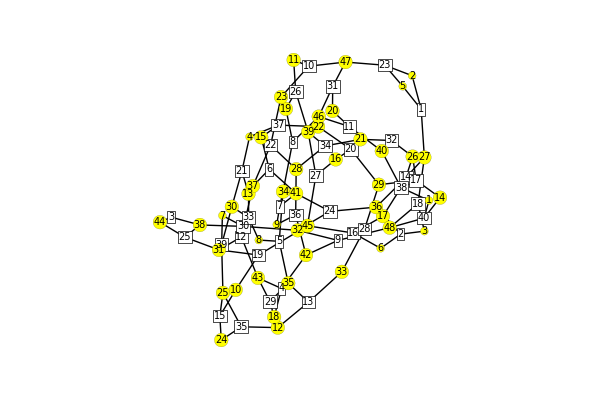

In [418]:
plot(lm.fg)

# 2. Decimation on basis

In [97]:
H = Int.(sprand(Bool, 25,30, 0.1))
maxvardeg = maximum(sum(H, dims=1))
B,indep = findbasis_slow(Array(H))
@assert iszero(H*sparse(B) .% 2)

In [103]:
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 10
init = OffsetArray(MVector{2J+1}(rand(2J+1)), -J:J)
y = 0.2
sp = survey_propagation(H; field=copy(s), init, y=y)
sp.efield[indep] .= (maxvardeg+1)*sp.J.*rand((-1,1), length(indep));

In [104]:
iteration!(sp; maxiter=1000, damp=0.5)

0.0009981028558310179

In [105]:
σ = sign.(argmax.(sp.survey))
x = σ .== -1
z = sp.H*x .% 2
nunsat = sum(z)

1

### a. Fix independent variables to random value

In [44]:
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 10
init = OffsetArray(MVector{2J+1}(rand(2J+1)), -J:J)
y = 0.2
sp = survey_propagation(H; field=copy(s), init, y=y);

In [45]:
maxvardeg = maximum(sum(H, dims=1))
B,indep = findbasis_slow(Array(H))
@assert iszero(H*sparse(B) .% 2)
sp.efield[indep] .= (maxvardeg+1)*sp.J.*rand((-1,1), length(indep));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [46]:
callback(t, ε, sp) = (println("$t $ε"); false)
iteration!(sp; maxiter=1000, damp=0.5, callback=callback)

1 0.8824098178019653
2 0.44120490890098263
3 0.22507930016643468
4 0.20472874640792604
5 0.2789877070866071
6 0.3215180276584392
7 0.31773054919339566
8 0.2948043483940054
9 0.28270183183922354
10 0.2828341208757291
11 0.28408981407647066
12 0.26972759369526367
13 0.24793951295528316
14 0.2441761572500864
15 0.2444177153688024
16 0.2286153130306513
17 0.21984765602103734
18 0.21481854146075252
19 0.20464124913680581
20 0.20127236828000872
21 0.19155563194881997
22 0.18523277783803033
23 0.18632513915446136
24 0.18410743582875833
25 0.17357627482658694
26 0.1714234362516649
27 0.1662009447442353
28 0.16251002738662718
29 0.15512253447067148
30 0.15487070579791412
31 0.15578137706051404
32 0.15599515066683078
33 0.15084075478938952
34 0.14081095813263533
35 0.1360555049305887
36 0.13671460539254232
37 0.13773517298480742
38 0.13440842987603402
39 0.12971306764412882
40 0.12619068611490414
41 0.12580136618641286
42 0.12661863166736476
43 0.12374453139960429
44 0.11985558688805864
45 0.118

344 0.01612502077917627
345 0.016289037946774
346 0.016383196420231616
347 0.01640754178724907
348 0.01636271039771786
349 0.016338522057315064
350 0.016294296323917434
351 0.01618269405891165
352 0.016005488494937825
353 0.01576499331763015
354 0.015464034607680144
355 0.015402132917573308
356 0.01561903466795117
357 0.015770660286633542
358 0.015856625192396
359 0.01587709493386974
360 0.015832780111882716
361 0.015812144001408235
362 0.015768534704325654
363 0.015661912908667253
364 0.015593643122982115
365 0.015616273602265751
366 0.015576279973455731
367 0.015553513645981176
368 0.015514171627288187
369 0.015413876714536645
370 0.015339525198913961
371 0.015364121347611004
372 0.015328160325661144
373 0.015303454649132797
374 0.015268095651282287
375 0.015173756973942576
376 0.01502199179321173
377 0.014838120327091697
378 0.014806843470964615
379 0.014780648543994968
380 0.014750011170730715
381 0.01466362984246622
382 0.01458762768730254
383 0.014613171074662923
384 0.0145832070

673 0.005041426207350486
674 0.005004048236209757
675 0.00498347680349015
676 0.0049625593080553365
677 0.004937376794274195
678 0.004914836322524319
679 0.004914660604887988
680 0.004912986473682657
681 0.004911388922978599
682 0.004911263618650796
683 0.004909565877599498
684 0.004908290244753921
685 0.004907868638249324
686 0.004905603892647936
687 0.004901352921623747
688 0.004894976576509835
689 0.004886340739280737
690 0.004875317376969779
691 0.0048617855505210805
692 0.004845632371414443
693 0.004826753899778602
694 0.004805055978127526
695 0.004780454995295447
696 0.004752878575630004
697 0.004722266189021496
698 0.0046885696778794506
699 0.004651753697750172
700 0.004653347323803125
701 0.004656590960175566
702 0.00465854520984188
703 0.0046591401229993945
704 0.0046582994081215134
705 0.004656857514344304
706 0.00465640152559299
707 0.004655409430116941
708 0.00465395522999823
709 0.0046536368759887425
710 0.004652494987821665
711 0.0046510287800548555
712 0.0046508467837506

996 0.0021711725111950297
997 0.0021697390011729545
998 0.0021693060683313226
999 0.0021683088648150606
1000 0.0021668820890690665


0.0021668820890690665

In [47]:
σ = sign.(argmax.(sp.survey))
x = σ .== -1
z = sp.H*x .% 2
nunsat = sum(z)

20

In [48]:
countmap(σ)

Dict{Int64,Int64} with 3 entries:
  0  => 5
  -1 => 3330
  1  => 3385

Check whether all fixed variables actually took those values

In [50]:
fields = sign.(sp.efield[indep])
surveys = sign.(argmax.(sp.survey[indep]))
fields == surveys

true

In [89]:
function decimate_basis!(sp, s, indep; decsteps=10, maxiter=500, damp=0.5, kw...)
    cnt = 0
    freevars = indep
    maxvardeg = maximum(sum(sp.H, dims=1))
    while !isempty(freevars)
        cnt += 1
        # rank variables
        mag = [findmax([sum(p[begin:-1]), sum(p[1:end])]) for p in sp.survey]
        mag_sign = [(m[2] - 1.5)*2 for m in mag]
        sort!(freevars, by=i->abs(mag[i][1]))
        # fix the highest-ranked with a strong field
        freevars, tofix = freevars[1:end-decsteps-1], freevars[max(1,end-decsteps+1):end]
        println("### Step $cnt")
        sp.efield[tofix] .= (maxvardeg+1)*sp.J.*mag_sign[tofix]  
        # run SP
        iteration!(sp; maxiter=maxiter, damp=damp, kw...)
        # print stuff
        nunsat, ovl, dist = performance(sp, s)
        println("Unsat ", nunsat, ". Free vars ", length(freevars), ". Ovl ", round(ovl,digits=3))
        # check that variables have been fixed
        fields = sign.(sp.efield[indep])
        surveys = sign.(argmax.(sp.survey[indep]))
        @assert fields == surveys
    end
    nunsat, ovl, dist = performance(sp, s)
end

decimate_basis! (generic function with 1 method)

In [78]:
x0 = rand((0,1), size(H,2))
src = (-1).^x0
J = 20
init=OffsetArray(MVector{2J+1}(rand(2J+1)), -J:J)
y = 0.2
sp = survey_propagation(H; field=copy(src), init, y=y)

In [79]:
B,indep = findbasis_slow(Array(H))
iszero(H*sparse(B) .% 2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


true

### Decsteps=#indep

In [81]:
callback(t, ε, sp) = (println("$t $ε"); false)
sp2 = deepcopy(sp);

In [ ]:
iteration!(sp2; maxiter=1000, damp=0.5, callback=callback)

In [90]:
decimate_basis!(sp2, src, indep, decsteps=length(indep), maxiter=100, damp=0.5, callback=callback, tol=1e-3)

### Step 1
1 0.008608737116090837
2 0.008606536235774953
3 0.008606856215991388
4 0.008601635989385126
5 0.008589042046652062
6 0.008569240466813677
7 0.008542415819552118
8 0.008508770730332238
9 0.00847003547118308
10 0.0085453146114286
11 0.008614597424543402
12 0.008677617594962217
13 0.00873413074241658
14 0.008783916922457724
15 0.008826782722938131
16 0.008862562950716635
17 0.008891121909773037
18 0.008912354278337253
19 0.008926185598411185
20 0.008932572396205929
21 0.008931501956426335
22 0.00892515849411668
23 0.008924075135558818
24 0.008915581934676897
25 0.0088997249608459
26 0.008876578311657335
27 0.008846242826627826
28 0.008885328011702387
29 0.008925596132066782
30 0.008958167015279517
31 0.00898313756460245
32 0.009000599976327739
33 0.009010641045308465
34 0.009013341645634942
35 0.009008776394883511
36 0.008997013507227702
37 0.008978114837484674
38 0.0089521361149687
39 0.008919127362841839
40 0.008879133495595881
41 0.008832195084359173
42 0.00877834927701715
4

(17, 0.5005952380952381, 0.24970238095238095)

### Decsteps = #indep / 2

In [ ]:
callback(t, ε, sp) = (println("$t $ε"); false)
sp2 = deepcopy(sp)
iteration!(sp2; maxiter=1000, damp=0.5, callback=callback)
decimate_basis!(sp2, src, indep, decsteps=length(indep)÷2, maxiter=1000, damp=0.5, callback=callback)

1 0.9784094070244576


In [39]:
callback(t, ε, sp) = (println("$t $ε"); false)
iteration!(sp; maxiter=100, damp=0.5, callback=callback, tol=1e-10)

1 17.716525311314854
2 17.706806943791207
3 17.70091330127218
4 17.697079458768485
5 17.68734673753761
6 17.672822168780158
7 17.64771231179043
8 17.611718652186028
9 17.56464631323547
10 17.506402205124232
11 17.436982189460878
12 17.356450030089036
13 17.264911587632923
14 17.162487884762186
15 17.04929038771911
16 16.925401231236947
17 16.790860293389414
18 16.645660167017468
19 16.489749533943268
20 16.32304523478888
21 16.247338712229975
22 16.381662967359944
23 16.497845543881112
24 16.593666719775
25 16.667053673934106
26 16.716107085631393
27 16.73913305938754
28 16.73468273368485
29 16.70159879463813
30 16.63906557029327
31 16.888852163305955
32 17.126573784817992
33 17.342764758810972
34 17.534906352038433
35 17.70079791670696
36 17.838573370484482
37 17.94669329647604
38 18.02392916970757
39 18.069367097479017
40 18.082450770120886
41 18.063061571008802
42 18.031047463169898
43 18.018921639366
44 17.999501958125393
45 17.968427325055245
46 17.95705866488629
47 17.93782084812

Check whether all fixed variables actually took those values

In [38]:
fields = sign.(sp.efield[indep])
surveys = sign.(argmax.(sp.survey[indep]))
sum(fields .!= surveys)

0